In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers import UniPCMultistepScheduler
from diffusers.utils.torch_utils import randn_tensor
from diffusers import DDIMScheduler
from diffusers import AutoencoderKL
from diffusers import StableDiffusionPipeline
import torch

In [ ]:
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 728.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load two Images for double explosure

Obtain the two boundary

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def prepare_hed_img(path):

    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Cannot load image from {path}")

    if img.dtype != np.uint8:
        img = (img * 255).clip(0, 255).astype(np.uint8)
    return img

def match_and_align(img1, img2):
    # SIFT
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # feature matching
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Ratio Test
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)

    print(f"Matching Points num：{len(good)}")
    if len(good) < 4:
        print("not enought matching point")
        return img2, None

    # get coordinates of points
    src_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)

    # Transfor
    M, mask = cv2.estimateAffinePartial2D(src_pts, dst_pts, method=cv2.RANSAC)

    h, w = img1.shape
    aligned = cv2.warpAffine(img2, M, (w, h), flags=cv2.INTER_LINEAR)

    return aligned, M

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Double-explosure-diffusion

/content/drive/MyDrive/Colab Notebooks/Double-explosure-diffusion


1. Get the HED Boundary

Processing flower2.jpg...


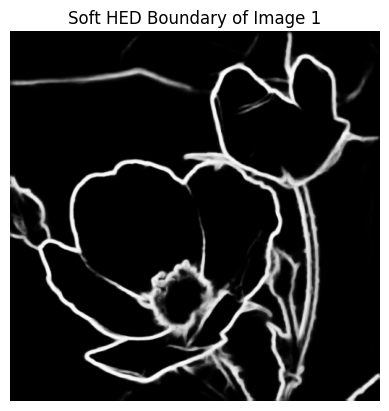

In [ ]:
import os
import numpy as np
import io
from controlnet_aux import HEDdetector
import torchvision.transforms as T
from PIL import Image
output_folder = './Hed Image'
hed = HEDdetector.from_pretrained("lllyasviel/Annotators")
path='./Source image/flower2.jpg'
img_name = os.path.basename(path)
print(f'Processing {img_name}...')

# Read Image
image = Image.open(path).convert("RGB")

# Get HED boundary
hed_result = hed(image)


# save image
hed_result.save(os.path.join(output_folder, f'hed_{img_name}'))
plt.imshow(hed_result, cmap="gray")
plt.axis("off")
plt.title("Soft HED Boundary of Image 1")
plt.show()

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Double-explosure-diffusion/Hed Image

/content/drive/MyDrive/Colab Notebooks/Double-explosure-diffusion/Hed Image


2. Combine the two Hed boundary based on SITF

Matching Points num：6


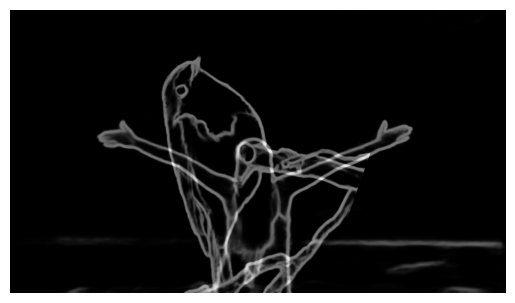

In [ ]:
from PIL import Image
img1 = prepare_hed_img('hed_laydy.jpg')
img2 = prepare_hed_img('hed_bird.jpg')

aligned_img2, M = match_and_align(img1, img2)
fused = ((img1.astype(np.float32) + aligned_img2.astype(np.float32)) / 2.0).clip(0, 255).astype(np.uint8)
fused=Image.fromarray(fused).convert("RGB")
plt.imshow(fused, cmap='gray')
plt.axis('off')
plt.show()

3. Use ControlNet to Generate Double Exposure Image

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch
from diffusers import UniPCMultistepScheduler

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-hed", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

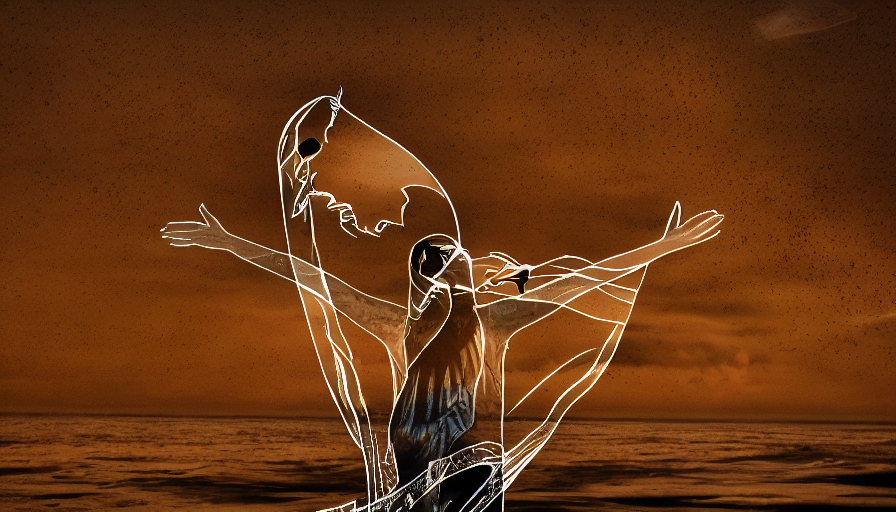

In [ ]:

prompt = "A silhouette of woman with a bird. overlapping effects, image blending, Transparency effect"
generator = torch.manual_seed(9)

output = pipe(
    prompt,
    fused,
    negative_prompt="bad anatomy, lowres, worst quality, low quality",
    generator=generator,
    num_inference_steps=50,
    controlnet_conditioning_scale = 1.0
)
output.images[0]

Generate the first image as conditional image for controlnet